Here is the library of functions:

In [247]:
def logistic(x):
    '''
    '''
    return 1/(1+np.exp(-x))

def U_logistic(theta, Y, X, phi):
    '''
    '''
    return - (Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))) - 0.5 * phi * np.sum(theta**2))

def gradU_logistic(theta, Y, X, phi):
    '''
    '''
    n = X.shape[0]
    
    Y_pred = logistic(X @ theta)
    epsilon = (Y[:,np.newaxis] - Y_pred[:,np.newaxis])
    grad = X.T @ epsilon - phi * theta[:, np.newaxis]

    return -grad/n


def hmc(Y, X, U, gradU, M, eps, m, theta0, phi):
    '''
    '''
    theta = theta0.copy()
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Intial energy
    H0 = U(theta0, Y, X, phi) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    r -= (eps/2)*gradU(theta, Y, X, phi)
    for i in range(m):
        theta += (eps*Minv@r).ravel()
        r -= eps*gradU(theta, Y, X, phi)
    r -= (eps/2)*gradU(theta, Y, X, phi)
    
    # Final energy
    H1 = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    # MH step
    u = np.random.uniform()
    rho = np.exp(H0 - H1) # Acceptance probability
    
    if u < np.min((1, rho)):
        # accept
        accept = True
        H = H1
    else:
        # reject
        theta = theta0
        accept = False
        H = H0

    return theta, accept, rho, H


def run_hmc(Y, X, U, gradU, M, eps, m, theta, phi, nsample):

    n, p = X.shape
    
    # Allocate space
    samples = np.zeros((nsample, p))
    accept = np.zeros(nsample)
    rho = np.zeros(nsample)
    H = np.zeros(nsample)
    
    # Run hmc
    for i in range(nsample):
        theta, accept[i], rho[i], H[i] = hmc(Y, X, U, gradU, M, eps, m, theta, phi)
        samples[i] = theta
        
    return samples, accept, rho, H  

def stogradU(theta, Y, X, nbatch, phi):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    n, p = X.shape
    
    # Sample minibatch
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    
    Y_pred = logistic(X[batch_id,:] @ theta[:,np.newaxis])
    epsilon = (Y[batch_id,np.newaxis] - Y_pred)
    grad = n/nbatch * X[batch_id,:].T @ epsilon - phi * theta[:, np.newaxis]

    #return -grad/n
    return -grad

def sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi):
    
    n, p = X.shape
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Hamiltonian dynamics
    for i in range(m):        
        theta += (eps*Minv@r).ravel()
        r -= eps*stogradU(theta, Y, X, nbatch,phi) - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(p),D)[:,np.newaxis] 
    
    # Record the energy
    H = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    return theta, H

def run_sghmc(Y, X, U, gradU, M, eps, m, theta, C, V, phi, nsample):
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    
    # Allocate space
    samples = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    # Run sghmc
    for i in range(nsample):
        theta, H[i] = sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi)
        samples[i] = theta
        
    return samples, H
    
    
def gd(Y, X, gradU, eps, m, theta, phi):
    '''
    '''
    samples = np.zeros((nsample, p))
    
    for i in range(m):
        theta -= eps*gradU(theta, Y, X, phi).ravel()
      
    return theta     

Everything after here is the script that runs the simulation:

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
pima = np.genfromtxt('pima-indians-diabetes.data', delimiter=',')

In [109]:
# Load data
X = np.concatenate((np.ones((pima.shape[0],1)),pima[:,0:8]), axis=1)
Y = pima[:,8]

Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
Xs = Xs[:,1:]

n, p = Xs.shape

### Regression

In [8]:
from sklearn.linear_model import LogisticRegression

In [122]:
# Unscaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(X,Y)
beta_true_unscale = mod_logis.coef_.ravel()
beta_true_unscale

array([ -8.31498612e+00,   1.22560027e-01,   3.49183220e-02,
        -1.34118967e-02,   6.28219471e-04,  -1.17179659e-03,
         8.86606033e-02,   9.30419443e-01,   1.46781178e-02])

In [121]:
# Scaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(Xs,Y)
beta_true_scale = mod_logis.coef_.ravel()
beta_true_scale

array([ 0.39024907,  1.08791914, -0.24544979,  0.02250608, -0.1621995 ,
        0.59035938,  0.32483104,  0.12120845])

### HMC

In [241]:
# HMC - Scaled
nsample = 1000
m = 20
eps = .001
theta = np.zeros(p)
#theta = beta_true_unscale.copy()
phi = 5
M = np.identity(p)

samples, accept, rho, H = run_hmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, phi, nsample)

np.mean(samples, axis=0) - beta_true_scale

array([-0.05995687, -0.21366711,  0.04524021, -0.02121641,  0.1368824 ,
       -0.06980019, -0.06679099,  0.05151616])

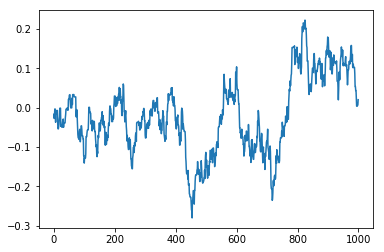

In [242]:
plt.plot((samples - beta_true_scale)[:,3])
plt.show()

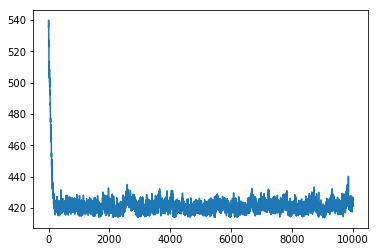

In [232]:
plt.plot(H)
plt.show()

### SGHMC

In [248]:
# HMC - Scaled (no intercept)
nsample = 1000
m = 20
eps = .002
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 500
C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)

samples, H = run_sghmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, C, V, phi, nsample)

np.mean(samples, axis=0) - beta_true_scale

array([-0.0391003 , -0.0805079 ,  0.03363423, -0.03836265,  0.0528513 ,
       -0.01430956, -0.0118171 ,  0.00262314])

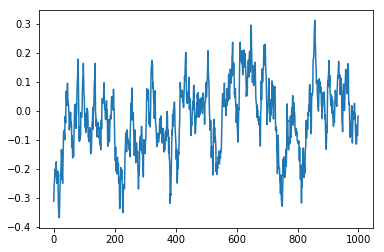

In [244]:
plt.plot((samples - beta_true_scale)[:,0])
plt.show()

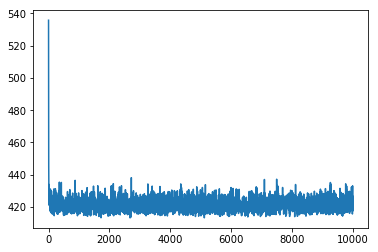

In [228]:
plt.plot(H)
plt.show()

### Gradient Descent

In [249]:
# Gradient descent - Scaled
np.random.seed(2)
phi = .1

res = gd(Y, Xs, gradU, .1, 20000, np.zeros(p), phi)

res - beta_true_scale

array([-0.00056779, -0.001654  ,  0.00055597, -0.00011762,  0.00074642,
       -0.00075326, -0.00043704,  0.00030849])